In [1]:
# Instala librerías requeridas
!pip install tensorflow scikit-learn matplotlib seaborn statsmodels kaggle opencv-python-headless tf-keras-vis --quiet
!pip install streamlit pdfkit
!apt-get install -y wkhtmltopdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  avahi-daemon geoclue-2.0 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas iio-sensor-proxy
  libavahi-core7 libavahi-glib1 libdaemon0 libevdev2 libgudev-1.0-0 libhyphen0
  libinput-bin libinput10 libjson-glib-1.0-0 libjson-glib-1.0-common
  libmbim-glib4 libmbim-proxy libmd4c0 libmm-glib0 libmtdev1 libnl-genl-3-200
  libnotify4 libnss-mdns libproxy1v5 libqmi-glib5 libqmi-proxy libqt5core5a
  libqt5dbus5 libqt5

In [2]:
from google.colab import files
files.upload()  # Subir kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
# Descarga el dataset
!kaggle datasets download -d zaldyjr/cacao-diseases
!unzip -q cacao-diseases.zip -d cacao_data

Dataset URL: https://www.kaggle.com/datasets/zaldyjr/cacao-diseases
License(s): CC-BY-SA-4.0
 99% 1.01G/1.01G [00:04<00:00, 186MB/s]
100% 1.01G/1.01G [00:05<00:00, 217MB/s]


In [4]:
import os
base_dir = 'cacao_data/cacao_diseases/cacao_photos'
clases = os.listdir(base_dir)
print("Clases encontradas:", clases)
for clase in clases:
    ruta = os.path.join(base_dir, clase)
    print(f"{clase}: {len(os.listdir(ruta))} imágenes")

Clases encontradas: ['healthy', 'black_pod_rot', 'pod_borer']
healthy: 3344 imágenes
black_pod_rot: 943 imágenes
pod_borer: 103 imágenes


In [7]:
import pandas as pd
import random

base_dir = 'cacao_data/cacao_diseases/cacao_photos'
clases = ['healthy', 'black_pod_rot', 'pod_borer']
imgs_per_class = 103

# Recolectar imágenes balanceadas
data = []
for clase in clases:
    ruta = os.path.join(base_dir, clase)
    imgs = os.listdir(ruta)
    # Filtrar solo archivos de imagen válidos
    imgs = [img for img in imgs if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    # Asegurarse de que hay suficientes imágenes para seleccionar
    if len(imgs) < imgs_per_class:
        print(f"Advertencia: La clase '{clase}' tiene menos de {imgs_per_class} imágenes. Usando todas las disponibles.")
        selected_imgs = imgs
    else:
        selected_imgs = random.sample(imgs, imgs_per_class)
    for img in selected_imgs:
        data.append({'filepath': os.path.join(ruta, img), 'label': clase})

df = pd.DataFrame(data)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # Mezclar

# Codificar etiquetas numéricas
label_dict = {clase: idx for idx, clase in enumerate(clases)}
df['label_num'] = df['label'].map(label_dict)

# Separar por clase
df_train, df_val, df_test = [], [], []
# Calcular el número de imágenes por conjunto para cada clase
# Asumiendo 103 imágenes por clase:
# 70% para entrenamiento (~72 imágenes)
# 15% para validación (~15 imágenes)
# 15% para prueba (~16 imágenes)
train_count = int(imgs_per_class * 0.70)
val_count = int(imgs_per_class * 0.15)
test_count = imgs_per_class - train_count - val_count # El resto para asegurar 103

for clase in clases:
    dft = df[df['label'] == clase]
    train = dft.iloc[:train_count]
    val = dft.iloc[train_count : train_count + val_count]
    test = dft.iloc[train_count + val_count : train_count + val_count + test_count] # Asegurar que no exceda el límite

    df_train.append(train)
    df_val.append(val)
    df_test.append(test)

df_train = pd.concat(df_train).sample(frac=1, random_state=42).reset_index(drop=True)
df_val = pd.concat(df_val).sample(frac=1, random_state=42).reset_index(drop=True)
df_test = pd.concat(df_test).sample(frac=1, random_state=42).reset_index(drop=True)

print("Train:", df_train['label'].value_counts())
print("Val:", df_val['label'].value_counts())
print("Test:", df_test['label'].value_counts())

Train: label
pod_borer        72
black_pod_rot    72
healthy          72
Name: count, dtype: int64
Val: label
pod_borer        15
black_pod_rot    15
healthy          15
Name: count, dtype: int64
Test: label
black_pod_rot    16
pod_borer        16
healthy          16
Name: count, dtype: int64


In [41]:
from PIL import Image
import numpy as np

IMG_SIZE = (128, 128)

def load_images(df):
    X = []
    y = []
    for i, row in df.iterrows():
        img = Image.open(row['filepath']).convert('RGB').resize(IMG_SIZE)
        X.append(np.array(img)/255.0)
        y.append(row['label_num'])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.int32)

X_train, y_train = load_images(df_train)
X_val, y_val = load_images(df_val)
X_test, y_test = load_images(df_test)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (216, 128, 128, 3) y_train: (216,)
X_val: (45, 128, 128, 3) y_val: (45,)
X_test: (48, 128, 128, 3) y_test: (48,)


In [11]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications

input_shape = (128, 128, 3)
num_classes = 3
EPOCHS = 30
BATCH_SIZE = 8

# Modelo 1: CNN sencilla
def build_cnn_simple(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modelo 2: CNN más profunda
def build_cnn_deep(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modelo 3: MobileNetV2 Transfer Learning
def build_mobilenet(input_shape, num_classes):
    base = applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False  # Congelar base
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Modelo 4: ResNet50 Transfer Learning (Nuevo)
def build_resnet50(input_shape, num_classes):
    base = applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base.trainable = False # Congelar base
    model = models.Sequential([
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

print("Entrenando CNN Simple...")
cnn_simple = build_cnn_simple(input_shape, num_classes)
history1 = cnn_simple.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

print("\nEntrenando CNN Profunda...")
cnn_deep = build_cnn_deep(input_shape, num_classes)
history2 = cnn_deep.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

print("\nEntrenando MobileNetV2...")
mobilenet = build_mobilenet(input_shape, num_classes)
history3 = mobilenet.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

print("\nEntrenando ResNet50...")
resnet50 = build_resnet50(input_shape, num_classes)
history4 = resnet50.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    verbose=2
)

# Guardar modelos
cnn_simple.save('cnn_simple.h5')
cnn_deep.save('cnn_deep.h5')
mobilenet.save('mobilenet.h5')
resnet50.save('resnet50.h5') # Guardar el nuevo modelo

Entrenando CNN Simple...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
27/27 - 9s - 331ms/step - accuracy: 0.3241 - loss: 1.4844 - val_accuracy: 0.3333 - val_loss: 1.0981
Epoch 2/30
27/27 - 5s - 198ms/step - accuracy: 0.4074 - loss: 1.0910 - val_accuracy: 0.4667 - val_loss: 1.0377
Epoch 3/30
27/27 - 11s - 399ms/step - accuracy: 0.6111 - loss: 0.9100 - val_accuracy: 0.5111 - val_loss: 0.9620
Epoch 4/30
27/27 - 5s - 195ms/step - accuracy: 0.6713 - loss: 0.7426 - val_accuracy: 0.6444 - val_loss: 0.7561
Epoch 5/30
27/27 - 10s - 377ms/step - accuracy: 0.8056 - loss: 0.4668 - val_accuracy: 0.6889 - val_loss: 0.6795
Epoch 6/30
27/27 - 10s - 378ms/step - accuracy: 0.9120 - loss: 0.2462 - val_accuracy: 0.7556 - val_loss: 0.6018
Epoch 7/30
27/27 - 10s - 379ms/step - accuracy: 0.9815 - loss: 0.0967 - val_accuracy: 0.7778 - val_loss: 0.5936
Epoch 8/30
27/27 - 11s - 418ms/step - accuracy: 0.9907 - loss: 0.0338 - val_accuracy: 0.7333 - val_loss: 0.9193
Epoch 9/30
27/27 - 10s - 388ms/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 0.7333 - val_loss: 0.

In [80]:
!pip install streamlit tensorflow pillow scikit-learn matplotlib

In [13]:
!apt-get install -y wkhtmltopdf
!pip install pdfkit

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
wkhtmltopdf is already the newest version (0.12.6-2).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.


In [83]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, accuracy_score
from statsmodels.stats.contingency_tables import mcnemar
from io import BytesIO
import base64
import os
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import tempfile
import cv2
import requests
import io

try:
    import pdfkit
    PDFKIT_AVAILABLE = True
except ImportError:
    PDFKIT_AVAILABLE = False

LANGUAGES = {
    'es': {'name': 'Español', 'flag': '🇪🇸'},
    'en': {'name': 'English', 'flag': '🇺🇸'},
    'it': {'name': 'Italiano', 'flag': '🇮🇹'}
}

TRANSLATIONS = {
    'es': {
        # Títulos principales
        'page_title': 'Diagnóstico Inteligente de Cacao - Deep Learning',
        'main_title': 'Diagnóstico Inteligente de Enfermedades del Cacao',
        'subtitle': 'Sistema avanzado con modelos deep learning (CNN Simple, CNN Profunda, MobileNetV2, ResNet50/GradCAM)',

        # Menús
        'control_panel': 'Panel de Control',
        'select_mode': 'Seleccionar Modo',
        'individual_diagnosis': 'Diagnóstico Individual',
        'disease_guide': 'Guía de Enfermedades',
        'comparative_analysis': 'Análisis Comparativo',
        'system_info': 'Información del Sistema',

        # Diagnóstico individual
        'select_image_source': 'Selecciona el origen de la imagen',
        'upload_from_computer': 'Subir desde mi computadora',
        'select_from_github': 'Seleccionar desde GitHub',
        'upload_image': 'Suba una imagen de mazorca de cacao para diagnóstico',
        'searching_images': 'Buscando imágenes públicas en la raíz del repositorio GitHub...',
        'choose_image': 'Elige una imagen',
        'load_selected_image': 'Cargar imagen seleccionada',
        'image_loaded': 'Imagen cargada',
        'automatic_diagnosis': 'Diagnóstico automático con IA',
        'processing': 'Procesando...',
        'ai_diagnosis': 'Diagnóstico por IA',
        'description': 'Descripción',
        'severity': 'Severidad',
        'gradcam_caption': 'Mapa de calor Grad-CAM (ResNet50)',
        'gradcam_description': 'Grad-CAM: Muestra qué regiones de la imagen influyeron más en la predicción del modelo ResNet50.',
        'model_confidence': 'Confianza de los modelos',
        'treatment_prevention': 'Tratamiento y medidas preventivas',
        'recommended_treatment': 'Tratamiento recomendado',
        'prevention': 'Prevención',
        'image_features': 'Características de la imagen cargada',
        'download_report': 'Descargar reporte individual',
        'download_html': 'Descargar reporte HTML',
        'download_pdf': 'Descargar reporte PDF',

        # Características de imagen
        'avg_brightness': 'Brillo promedio',
        'texture_variance': 'Varianza de textura',
        'contrast': 'Contraste',

        # Guía de enfermedades
        'disease_guide_title': 'Guía Completa de Enfermedades del Cacao',
        'example_image': 'Ejemplo de',
        'example_not_available': 'Imagen de ejemplo no disponible para',
        'general_info': 'Información General',
        'symptoms': 'Síntomas Característicos',
        'preventive_measures': 'Medidas Preventivas',
        'recommended_treatment': 'Tratamiento Recomendado',

        # Análisis comparativo
        'comparative_analysis_title': 'Análisis Comparativo de Modelos',
        'performance_analysis': 'Análisis de Rendimiento',
        'generate_report': 'Generar Reporte',
        'model_evaluation': 'Evaluación de Modelos de IA',
        'instructions': 'Instrucciones',
        'download_example': 'Descargar archivo de ejemplo',
        'select_csv_source': 'Selecciona el origen del CSV',
        'load_csv': 'Cargar archivo de resultados CSV',
        'searching_csv': 'Buscando archivos CSV públicos en la raíz del repositorio GitHub...',
        'choose_csv': 'Elige un archivo CSV',
        'load_selected_csv': 'Cargar CSV seleccionado',
        'file_loaded': 'Archivo cargado exitosamente',
        'samples_found': 'muestras encontradas',
        'best_model': 'El mejor modelo es',
        'statistical_analysis': 'Análisis Estadístico (Prueba de McNemar)',
        'significant': 'Significativa',
        'not_significant': 'No significativa',
        'generate_comparative_report': 'Generar Reporte Comparativo',
        'generating_report': 'Generando reporte completo...',
        'report_generated': 'Reporte PDF generado exitosamente',
        'pdfkit_not_available': 'pdfkit no disponible. Descargando como HTML.',

        # Métricas
        'precision': 'Precisión',
        'recall': 'Recall',
        'f1_score': 'F1-Score',
        'mcc': 'MCC',
        'avg_specificity': 'Especificidad Promedio',
        'model': 'Modelo',
        'confidence': 'Confianza',
        'prediction': 'Predicción',

        # Enfermedades
        'healthy': 'Sano',
        'black_pod_rot': 'Pudrición Negra (Black Pod Rot)',
        'pod_borer': 'Barrenador de Mazorca (Pod Borer)',

        # Mensajes
        'error_loading_models': 'Error cargando modelos',
        'error_loading_image': 'No se pudo cargar la imagen seleccionada desde GitHub',
        'error_loading_csv': 'No se pudo cargar el archivo CSV seleccionado desde GitHub',
        'no_images_found': 'No se encontraron imágenes en la raíz del repositorio',
        'no_csv_found': 'No se encontraron archivos CSV en la raíz del repositorio',
        'csv_loaded_success': 'CSV cargado correctamente desde GitHub',
        'image_loaded_success': 'Imagen cargada correctamente desde GitHub',
        'analysis_first': 'Primero realiza el análisis en la pestaña Análisis de Rendimiento',
        'report_includes': 'El reporte incluirá métricas detalladas, matrices de confusión y análisis estadístico.',

        # Información del sistema
        'available_models': 'Modelos Disponibles',
        'detected_diseases': 'Enfermedades Detectadas',
        'healthy_pods': 'Mazorcas Sanas',
        'black_rot': 'Pudrición Negra',
        'pod_borer_pest': 'Barrenador de Mazorca',

        # Severidad
        'none': 'Ninguna',
        'high': 'Alta',
        'medium_high': 'Media-Alta',

        # Instrucciones detalladas
        'detailed_instructions': [
            'Sube un archivo CSV con las columnas: y_true, y_pred1, y_pred2, y_pred3',
            'El sistema comparará automáticamente los tres modelos',
            'Genera métricas avanzadas y pruebas estadísticas'
        ],

        'project_title': 'Sistema de Diagnóstico de Enfermedades en Cacao',
        'project_subtitle': 'Inteligencia Artificial para la Salud del Cacao',
        'about_project': '🌱 Sobre el Proyecto',
        'about_project_desc': 'Este proyecto implementa un sistema automático de diagnóstico de enfermedades del cacao utilizando <strong>redes neuronales convolucionales (CNN)</strong> y técnicas de <strong>Deep Learning</strong>. El sistema puede identificar automáticamente el estado fitosanitario de las mazorcas de cacao, ayudando a los productores a tomar decisiones informadas para el cuidado de sus cultivos.',
        'main_features': '🚀 Características del Sistema',
        'feature_1_title': '🧠 Deep Learning Avanzado',
        'feature_1_desc': '4 arquitecturas CNN especializadas en análisis de imágenes de cacao con transfer learning',
        'feature_2_title': '📊 Validación Estadística',
        'feature_2_desc': 'Pruebas de McNemar para comparación robusta de modelos y métricas avanzadas',
        'feature_3_title': '🎯 Interpretabilidad',
        'feature_3_desc': 'Mapas de calor Grad-CAM para entender qué características analiza el modelo',
        'feature_4_title': '📱 Interfaz Intuitiva',
        'feature_4_desc': 'Aplicación web moderna con reportes PDF automáticos y visualizaciones interactivas',
        'detected_states': '🔍 Estados Fitosanitarios Detectados',
        'healthy_title': 'Sano (Healthy)',
        'healthy_desc': 'Mazorca sin síntomas, color uniforme y sin lesiones visibles',
        'blackpod_title': 'Pudrición Negra',
        'blackpod_desc': 'Manchas marrón-negruzcas causadas por Phytophthora',
        'podborer_title': 'Barrenador de Mazorca',
        'podborer_desc': 'Daño causado por larvas de Conopomorpha',
        'tech_stack': '🛠️ Stack Tecnológico',
        'hardware_specs': '💻 Especificaciones de Hardware',
        'cta_phrase': '🎯 Revolucionando el diagnóstico agrícola con Inteligencia Artificial',
        'cta_phrase': '🎯 Revolucionando el diagnóstico agrícola con Inteligencia Artificial',
        'tech_stack': '🛠️ Stack Tecnológico',
        'hardware_specs': '💻 Especificaciones de Hardware',
    },
    'en': {
        # Main titles
        'page_title': 'Intelligent Cacao Diagnosis - Deep Learning',
        'main_title': 'Intelligent Cacao Disease Diagnosis',
        'subtitle': 'Advanced system with deep learning models (Simple CNN, Deep CNN, MobileNetV2, ResNet50/GradCAM)',

        # Menus
        'control_panel': 'Control Panel',
        'select_mode': 'Select Mode',
        'individual_diagnosis': 'Individual Diagnosis',
        'disease_guide': 'Disease Guide',
        'comparative_analysis': 'Comparative Analysis',
        'system_info': 'System Information',

        # Individual diagnosis
        'select_image_source': 'Select image source',
        'upload_from_computer': 'Upload from my computer',
        'select_from_github': 'Select from GitHub',
        'upload_image': 'Upload a cacao pod image for diagnosis',
        'searching_images': 'Searching for public images in the GitHub repository root...',
        'choose_image': 'Choose an image',
        'load_selected_image': 'Load selected image',
        'image_loaded': 'Image loaded',
        'automatic_diagnosis': 'Automatic AI diagnosis',
        'processing': 'Processing...',
        'ai_diagnosis': 'AI Diagnosis',
        'description': 'Description',
        'severity': 'Severity',
        'gradcam_caption': 'Grad-CAM heatmap (ResNet50)',
        'gradcam_description': 'Grad-CAM: Shows which regions of the image most influenced the ResNet50 model prediction.',
        'model_confidence': 'Model confidence',
        'treatment_prevention': 'Treatment and preventive measures',
        'recommended_treatment': 'Recommended treatment',
        'prevention': 'Prevention',
        'image_features': 'Loaded image features',
        'download_report': 'Download individual report',
        'download_html': 'Download HTML report',
        'download_pdf': 'Download PDF report',

        # Image features
        'avg_brightness': 'Average brightness',
        'texture_variance': 'Texture variance',
        'contrast': 'Contrast',

        # Disease guide
        'disease_guide_title': 'Complete Cacao Disease Guide',
        'example_image': 'Example of',
        'example_not_available': 'Example image not available for',
        'general_info': 'General Information',
        'symptoms': 'Characteristic Symptoms',
        'preventive_measures': 'Preventive Measures',
        'recommended_treatment': 'Recommended Treatment',

        # Comparative analysis
        'comparative_analysis_title': 'Model Comparative Analysis',
        'performance_analysis': 'Performance Analysis',
        'generate_report': 'Generate Report',
        'model_evaluation': 'AI Model Evaluation',
        'instructions': 'Instructions',
        'download_example': 'Download example file',
        'select_csv_source': 'Select CSV source',
        'load_csv': 'Load CSV results file',
        'searching_csv': 'Searching for public CSV files in the GitHub repository root...',
        'choose_csv': 'Choose a CSV file',
        'load_selected_csv': 'Load selected CSV',
        'file_loaded': 'File loaded successfully',
        'samples_found': 'samples found',
        'best_model': 'The best model is',
        'statistical_analysis': 'Statistical Analysis (McNemar Test)',
        'significant': 'Significant',
        'not_significant': 'Not significant',
        'generate_comparative_report': 'Generate Comparative Report',
        'generating_report': 'Generating complete report...',
        'report_generated': 'PDF report generated successfully',
        'pdfkit_not_available': 'pdfkit not available. Downloading as HTML.',

        # Metrics
        'precision': 'Precision',
        'recall': 'Recall',
        'f1_score': 'F1-Score',
        'mcc': 'MCC',
        'avg_specificity': 'Average Specificity',
        'model': 'Model',
        'confidence': 'Confidence',
        'prediction': 'Prediction',

        # Diseases
        'healthy': 'Healthy',
        'black_pod_rot': 'Black Pod Rot',
        'pod_borer': 'Pod Borer',

        # Messages
        'error_loading_models': 'Error loading models',
        'error_loading_image': 'Could not load selected image from GitHub',
        'error_loading_csv': 'Could not load selected CSV file from GitHub',
        'no_images_found': 'No images found in repository root',
        'no_csv_found': 'No CSV files found in repository root',
        'csv_loaded_success': 'CSV loaded successfully from GitHub',
        'image_loaded_success': 'Image loaded successfully from GitHub',
        'analysis_first': 'First perform the analysis in the Performance Analysis tab',
        'report_includes': 'The report will include detailed metrics, confusion matrices and statistical analysis.',

        # System information
        'available_models': 'Available Models',
        'detected_diseases': 'Detected Diseases',
        'healthy_pods': 'Healthy Pods',
        'black_rot': 'Black Rot',
        'pod_borer_pest': 'Pod Borer',

        # Severity
        'none': 'None',
        'high': 'High',
        'medium_high': 'Medium-High',

        # Detailed instructions
        'detailed_instructions': [
            'Upload a CSV file with columns: y_true, y_pred1, y_pred2, y_pred3',
            'The system will automatically compare the three models',
            'Generate advanced metrics and statistical tests'
        ],
        'project_title': 'Cacao Disease Diagnosis System',
        'project_subtitle': 'Artificial Intelligence for Cacao Health',
        'about_project': '🌱 About the Project',
        'about_project_desc': 'This project implements an automatic system for diagnosing cacao diseases using <strong>convolutional neural networks (CNNs)</strong> and <strong>Deep Learning</strong> techniques. The system can automatically identify the phytosanitary status of cacao pods, helping producers make informed decisions for crop care.',
        'main_features': '🚀 System Features',
        'feature_1_title': '🧠 Advanced Deep Learning',
        'feature_1_desc': '4 specialized CNN architectures for cacao image analysis with transfer learning',
        'feature_2_title': '📊 Statistical Validation',
        'feature_2_desc': 'McNemar tests for robust model comparison and advanced metrics',
        'feature_3_title': '🎯 Interpretability',
        'feature_3_desc': 'Grad-CAM heatmaps to understand which features the model analyzes',
        'feature_4_title': '📱 Intuitive Interface',
        'feature_4_desc': 'Modern web application with automatic PDF reports and interactive visualizations',
        'detected_states': '🔍 Detected Phytosanitary States',
        'healthy_title': 'Healthy',
        'healthy_desc': 'Pod with no symptoms, uniform color and no visible lesions',
        'blackpod_title': 'Black Pod Rot',
        'blackpod_desc': 'Dark brown to black spots caused by Phytophthora',
        'podborer_title': 'Pod Borer',
        'podborer_desc': 'Damage caused by Conopomorpha larvae',
        'tech_stack': '🛠️ Tech Stack',
        'hardware_specs': '💻 Hardware Specifications',
        'cta_phrase': '🎯 Revolutionizing agricultural diagnosis with Artificial Intelligence',

    },
    'it': {
        # Titoli principali
        'page_title': 'Diagnosi Intelligente del Cacao - Deep Learning',
        'main_title': 'Diagnosi Intelligente delle Malattie del Cacao',
        'subtitle': 'Sistema avanzato con modelli deep learning (CNN Semplice, CNN Profonda, MobileNetV2, ResNet50/GradCAM)',

        # Menu
        'control_panel': 'Pannello di Controllo',
        'select_mode': 'Seleziona Modalità',
        'individual_diagnosis': 'Diagnosi Individuale',
        'disease_guide': 'Guida alle Malattie',
        'comparative_analysis': 'Analisi Comparativa',
        'system_info': 'Informazioni del Sistema',

        # Diagnosi individuale
        'select_image_source': 'Seleziona la fonte dell\'immagine',
        'upload_from_computer': 'Carica dal mio computer',
        'select_from_github': 'Seleziona da GitHub',
        'upload_image': 'Carica un\'immagine di baccello di cacao per la diagnosi',
        'searching_images': 'Ricerca immagini pubbliche nella radice del repository GitHub...',
        'choose_image': 'Scegli un\'immagine',
        'load_selected_image': 'Carica immagine selezionata',
        'image_loaded': 'Immagine caricata',
        'automatic_diagnosis': 'Diagnosi automatica con IA',
        'processing': 'Elaborazione...',
        'ai_diagnosis': 'Diagnosi IA',
        'description': 'Descrizione',
        'severity': 'Severità',
        'gradcam_caption': 'Mappa di calore Grad-CAM (ResNet50)',
        'gradcam_description': 'Grad-CAM: Mostra quali regioni dell\'immagine hanno influenzato maggiormente la predizione del modello ResNet50.',
        'model_confidence': 'Confidenza dei modelli',
        'treatment_prevention': 'Trattamento e misure preventive',
        'recommended_treatment': 'Trattamento raccomandato',
        'prevention': 'Prevenzione',
        'image_features': 'Caratteristiche dell\'immagine caricata',
        'download_report': 'Scarica rapporto individuale',
        'download_html': 'Scarica rapporto HTML',
        'download_pdf': 'Scarica rapporto PDF',

        # Caratteristiche immagine
        'avg_brightness': 'Luminosità media',
        'texture_variance': 'Varianza texture',
        'contrast': 'Contrasto',

        # Guida malattie
        'disease_guide_title': 'Guida Completa alle Malattie del Cacao',
        'example_image': 'Esempio di',
        'example_not_available': 'Immagine di esempio non disponibile per',
        'general_info': 'Informazioni Generali',
        'symptoms': 'Sintomi Caratteristici',
        'preventive_measures': 'Misure Preventive',
        'recommended_treatment': 'Trattamento Raccomandato',

        # Analisi comparativa
        'comparative_analysis_title': 'Analisi Comparativa dei Modelli',
        'performance_analysis': 'Analisi delle Prestazioni',
        'generate_report': 'Genera Rapporto',
        'model_evaluation': 'Valutazione Modelli IA',
        'instructions': 'Istruzioni',
        'download_example': 'Scarica file di esempio',
        'select_csv_source': 'Seleziona la fonte del CSV',
        'load_csv': 'Carica file CSV dei risultati',
        'searching_csv': 'Ricerca file CSV pubblici nella radice del repository GitHub...',
        'choose_csv': 'Scegli un file CSV',
        'load_selected_csv': 'Carica CSV selezionato',
        'file_loaded': 'File caricato con successo',
        'samples_found': 'campioni trovati',
        'best_model': 'Il modello migliore è',
        'statistical_analysis': 'Analisi Statistica (Test di McNemar)',
        'significant': 'Significativa',
        'not_significant': 'Non significativa',
        'generate_comparative_report': 'Genera Rapporto Comparativo',
        'generating_report': 'Generazione rapporto completo...',
        'report_generated': 'Rapporto PDF generato con successo',
        'pdfkit_not_available': 'pdfkit non disponibile. Scaricando come HTML.',

        # Metriche
        'precision': 'Precisione',
        'recall': 'Richiamo',
        'f1_score': 'F1-Score',
        'mcc': 'MCC',
        'avg_specificity': 'Specificità Media',
        'model': 'Modello',
        'confidence': 'Confidenza',
        'prediction': 'Predizione',

        # Malattie
        'healthy': 'Sano',
        'black_pod_rot': 'Marciume Nero del Baccello',
        'pod_borer': 'Perforatore del Baccello',

        # Messaggi
        'error_loading_models': 'Errore nel caricamento dei modelli',
        'error_loading_image': 'Impossibile caricare l\'immagine selezionata da GitHub',
        'error_loading_csv': 'Impossibile caricare il file CSV selezionato da GitHub',
        'no_images_found': 'Nessuna immagine trovata nella radice del repository',
        'no_csv_found': 'Nessun file CSV trovato nella radice del repository',
        'csv_loaded_success': 'CSV caricato con successo da GitHub',
        'image_loaded_success': 'Immagine caricata con successo da GitHub',
        'analysis_first': 'Prima esegui l\'analisi nella scheda Analisi delle Prestazioni',
        'report_includes': 'Il rapporto includerà metriche dettagliate, matrici di confusione e analisi statistica.',

        # Informazioni sistema
        'available_models': 'Modelli Disponibili',
        'detected_diseases': 'Malattie Rilevate',
        'healthy_pods': 'Baccelli Sani',
        'black_rot': 'Marciume Nero',
        'pod_borer_pest': 'Perforatore del Baccello',

        # Severità
        'none': 'Nessuna',
        'high': 'Alta',
        'medium_high': 'Media-Alta',

        # Istruzioni dettagliate
        'detailed_instructions': [
            'Carica un file CSV con le colonne: y_true, y_pred1, y_pred2, y_pred3',
            'Il sistema confronterà automaticamente i tre modelli',
            'Genera metriche avanzate e test statistici'
        ],
        'project_title': 'Sistema di Diagnosi delle Malattie del Cacao',
        'project_subtitle': 'Intelligenza Artificiale per la Salute del Cacao',
        'about_project': '🌱 Sul Progetto',
        'about_project_desc': 'Questo progetto implementa un sistema automatico per la diagnosi delle malattie del cacao utilizzando <strong>reti neurali convoluzionali (CNN)</strong> e tecniche di <strong>Deep Learning</strong>. Il sistema può identificare automaticamente lo stato fitosanitario delle cabosse di cacao, aiutando i produttori a prendere decisioni informate per la cura delle coltivazioni.',
        'main_features': '🚀 Caratteristiche del Sistema',
        'feature_1_title': '🧠 Deep Learning Avanzato',
        'feature_1_desc': '4 architetture CNN specializzate nell’analisi delle immagini di cacao con transfer learning',
        'feature_2_title': '📊 Validazione Statistica',
        'feature_2_desc': 'Test di McNemar per il confronto robusto dei modelli e metriche avanzate',
        'feature_3_title': '🎯 Interpretabilità',
        'feature_3_desc': 'Mappe di calore Grad-CAM per capire quali caratteristiche analizza il modello',
        'feature_4_title': '📱 Interfaccia Intuitiva',
        'feature_4_desc': 'Applicazione web moderna con report PDF automatici e visualizzazioni interattive',
        'detected_states': '🔍 Stati Fitosanitari Rilevati',
        'healthy_title': 'Sano',
        'healthy_desc': 'Cabossa senza sintomi, colore uniforme e nessuna lesione visibile',
        'blackpod_title': 'Marciume Nero',
        'blackpod_desc': 'Macchie marroni-nere causate da Phytophthora',
        'podborer_title': 'Perforatore del Baccello',
        'podborer_desc': 'Danni causati da larve di Conopomorpha',
        'tech_stack': '🛠️ Stack Tecnologico',
        'hardware_specs': '💻 Specifiche Hardware',
        'cta_phrase': '🎯 Rivoluzionando la diagnosi agricola con l’Intelligenza Artificiale',
    }
}

def get_text(key, lang='es'):
    return TRANSLATIONS.get(lang, TRANSLATIONS['es']).get(key, key)

def init_language():
    if 'language' not in st.session_state:
        st.session_state.language = 'es'

def language_selector():
    st.sidebar.markdown("### 🌐 Idioma / Language / Lingua")
    language_options = [f"{LANGUAGES[lang]['flag']} {LANGUAGES[lang]['name']}" for lang in LANGUAGES.keys()]
    current_lang_index = list(LANGUAGES.keys()).index(st.session_state.language)
    selected_lang = st.sidebar.selectbox(
        "Seleccionar idioma",
        language_options,
        index=current_lang_index,
        key="language_selector"
    )
    selected_lang_code = list(LANGUAGES.keys())[language_options.index(selected_lang)]
    if selected_lang_code != st.session_state.language:
        st.session_state.language = selected_lang_code
        st.rerun()

GITHUB_USER = "DanteVas"
GITHUB_REPO = "Sistema-de-diagnostico-de-enfermedades-del-cacao-usando-deep-learning"
GITHUB_IMG_FOLDER = ""

def listar_imagenes_github(user, repo, carpeta):
    api_url = f"https://api.github.com/repos/{user}/{repo}/contents/{carpeta}".rstrip("/")
    r = requests.get(api_url)
    files = []
    if r.status_code == 200:
        content = r.json()
        for file in content:
            if file['type'] == 'file' and (file['name'].lower().endswith('.jpg') or file['name'].lower().endswith('.png')):
                files.append(file['name'])
    return files

def listar_archivos_github(user, repo, carpeta, extensiones):
    api_url = f"https://api.github.com/repos/{user}/{repo}/contents/{carpeta}".rstrip("/")
    r = requests.get(api_url)
    files = []
    if r.status_code == 200:
        content = r.json()
        for file in content:
            if file['type'] == 'file' and any(file['name'].lower().endswith(ext) for ext in extensiones):
                files.append(file['name'])
    return files

def get_github_image_url(user, repo, carpeta, filename):
    if carpeta == "":
        return f"https://raw.githubusercontent.com/{user}/{repo}/main/{filename}"
    else:
        return f"https://raw.githubusercontent.com/{user}/{repo}/main/{carpeta}/{filename}"

def cargar_imagen_desde_github(url):
    r = requests.get(url)
    if r.status_code == 200:
        return Image.open(BytesIO(r.content)).convert("RGB")
    else:
        return None

DISEASE_INFO = {
    0: {
        'name': {
            'es': 'Sano',
            'en': 'Healthy',
            'it': 'Sano',
        },
        'desc': {
            'es': 'Mazorca sin síntomas evidentes. Color uniforme y sin lesiones visibles.',
            'en': 'Pod with no visible symptoms. Uniform color and no visible lesions.',
            'it': 'Cabossa senza sintomi evidenti. Colore uniforme e nessuna lesione visibile.',
        },
        'treatment': {
            'es': 'No requiere tratamiento. Mantenga prácticas agrícolas preventivas.',
            'en': 'No treatment required. Maintain preventive agricultural practices.',
            'it': 'Non richiede trattamento. Mantenere pratiche agricole preventive.',
        },
        'symptoms': {
            'es': 'Fruto y hoja sin manchas ni daños.',
            'en': 'Fruit and leaf without spots or damage.',
            'it': 'Frutto e foglia senza macchie né danni.',
        },
        'prevention': {
            'es': 'Mantener buen drenaje, inspección regular, manejo integrado de plagas.',
            'en': 'Maintain good drainage, regular inspection, integrated pest management.',
            'it': 'Mantenere un buon drenaggio, ispezione regolare, gestione integrata dei parassiti.',
        },
        'severity': {
            'es': 'Ninguna',
            'en': 'None',
            'it': 'Nessuna',
        },
        'color': '#43A047',
        'bg': '#E9FCE7',
        'class': 'healthy'
    },
    1: {
        'name': {
            'es': 'Pudrición Negra',
            'en': 'Black Pod Rot',
            'it': 'Marciume Nero',
        },
        'desc': {
            'es': 'Enfermedad causada por Phytophthora spp., con manchas marrón-negruzcas, generalmente en la base o extremo de la mazorca.',
            'en': 'Disease caused by Phytophthora spp., with dark brown to black spots, usually at the base or tip of the pod.',
            'it': 'Malattia causata da Phytophthora spp., con macchie marrone-nere, generalmente alla base o all’estremità della cabossa.',
        },
        'treatment': {
            'es': '1. Retirar y destruir frutos enfermos\n2. Aplicar fungicidas (a base de cobre)\n3. Mejorar el drenaje del suelo\n4. Podar ramas bajas\n5. Aplicar materia orgánica',
            'en': '1. Remove and destroy infected pods\n2. Apply fungicides (copper-based)\n3. Improve soil drainage\n4. Prune lower branches\n5. Apply organic matter',
            'it': '1. Rimuovere e distruggere i frutti malati\n2. Applicare fungicidi (a base di rame)\n3. Migliorare il drenaggio del suolo\n4. Potare i rami bassi\n5. Applicare materia organica',
        },
        'symptoms': {
            'es': 'Manchas marrón oscuro o negras, consistencia húmeda, progresión rápida.',
            'en': 'Dark brown or black spots, moist consistency, rapid progression.',
            'it': 'Macchie marrone scuro o nere, consistenza umida, progressione rapida.',
        },
        'prevention': {
            'es': 'Mejorar ventilación, evitar humedad excesiva, aplicar fungicidas preventivos.',
            'en': 'Improve ventilation, avoid excessive humidity, apply preventive fungicides.',
            'it': 'Migliorare la ventilazione, evitare l’umidità eccessiva, applicare fungicidi preventivi.',
        },
        'severity': {
            'es': 'Alta',
            'en': 'High',
            'it': 'Alta',
        },
        'color': '#6D4C41',
        'bg': '#F9ECE4',
        'class': 'pudricion'
    },
    2: {
        'name': {
            'es': 'Barrenador de Mazorca',
            'en': 'Pod Borer',
            'it': 'Perforatore del Baccello',
        },
        'desc': {
            'es': 'Plaga causada por larvas que se alimentan del interior de la mazorca. Provoca daños internos, galerías y pérdida de semillas.',
            'en': 'Pest caused by larvae that feed inside the pod. Causes internal damage, tunnels, and seed loss.',
            'it': 'Parassita causato da larve che si nutrono dell’interno della cabossa. Provoca danni interni, gallerie e perdita di semi.',
        },
        'treatment': {
            'es': '1. Recolectar y destruir frutos infestados\n2. Uso de trampas de feromonas\n3. Control biológico\n4. Aplicaciones de insecticidas específicos\n5. Limpieza del cultivo',
            'en': '1. Collect and destroy infested pods\n2. Use pheromone traps\n3. Biological control\n4. Apply specific insecticides\n5. Clean the crop',
            'it': '1. Raccogliere e distruggere i frutti infestati\n2. Utilizzare trappole a feromoni\n3. Controllo biologico\n4. Applicare insetticidi specifici\n5. Pulizia della coltivazione',
        },
        'symptoms': {
            'es': 'Orificios pequeños, daños en semillas, frutos deformados, presencia de larvas.',
            'en': 'Small holes, seed damage, deformed fruits, presence of larvae.',
            'it': 'Piccoli fori, danni ai semi, frutti deformati, presenza di larve.',
        },
        'prevention': {
            'es': 'Monitoreo con trampas, control biológico, manejo de residuos.',
            'en': 'Monitor with traps, biological control, waste management.',
            'it': 'Monitoraggio con trappole, controllo biologico, gestione dei residui.',
        },
        'severity': {
            'es': 'Media-Alta',
            'en': 'Medium-High',
            'it': 'Media-Alta',
        },
        'color': '#FFB300',
        'bg': '#FFF8E1',
        'class': 'barrenador'
    }
}
MODEL_NAMES = ['CNN Simple', 'CNN Profunda', 'MobileNetV2']
IMG_HEIGHT_GRADCAM, IMG_WIDTH_GRADCAM = 224, 224

METRIC_DESCRIPTIONS = {
    "Precisión": "Porcentaje de predicciones correctas sobre el total de muestras.",
    "Recall": "Capacidad del modelo para encontrar todos los casos positivos (sensibilidad).",
    "F1-Score": "Promedio armónico entre precisión y recall; balance entre falsos positivos y negativos.",
    "MCC": "Medida global de calidad del modelo (-1 a 1, donde 1 es perfecto, 0 es azar).",
    "Especificidad Promedio": "Capacidad de identificar correctamente los negativos (verdaderos negativos / (verdaderos negativos + falsos positivos))."
}

MODEL_NAMES = ['CNN Simple', 'CNN Profunda', 'MobileNetV2']
IMG_HEIGHT_GRADCAM, IMG_WIDTH_GRADCAM = 224, 224

METRIC_DESCRIPTIONS = {
    "Precisión": "Porcentaje de predicciones correctas sobre el total de muestras.",
    "Recall": "Capacidad del modelo para encontrar todos los casos positivos (sensibilidad).",
    "F1-Score": "Promedio armónico entre precisión y recall; balance entre falsos positivos y negativos.",
    "MCC": "Medida global de calidad del modelo (-1 a 1, donde 1 es perfecto, 0 es azar).",
    "Especificidad Promedio": "Capacidad de identificar correctamente los negativos (verdaderos negativos / (verdaderos negativos + falsos positivos))."
}

def get_classes(lang):
    return [DISEASE_INFO[i]['name'][lang] for i in range(len(DISEASE_INFO))]

def plot_confusion_matrix_mpl(y_true, y_pred, classes, title='Matriz de Confusión'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')
    plt.tight_layout()
    return fig

def fig_to_base64(fig):
    buf = BytesIO()
    fig.savefig(buf, format="png")
    buf.seek(0)
    img_base64 = base64.b64encode(buf.read()).decode("utf-8")
    plt.close(fig)
    return img_base64

def create_confidence_chart(predictions, model_names, lang):
    class_names = get_classes(lang)
    df_conf = pd.DataFrame({
        'Modelo': model_names,
        'Confianza': [float(np.max(pred)) * 100 for pred in predictions],
        'Predicción': [class_names[int(np.argmax(pred))] for pred in predictions]
    })
    fig = px.bar(df_conf, x='Modelo', y='Confianza',
                 color='Predicción',
                 title='Confianza por Modelo')
    fig.update_layout(height=400)
    return fig

def mcc_per_class(y_true, y_pred, n_classes=3):
    mccs = []
    for c in range(n_classes):
        y_true_bin = (np.array(y_true) == c).astype(int)
        y_pred_bin = (np.array(y_pred) == c).astype(int)
        mcc = matthews_corrcoef(y_true_bin, y_pred_bin)
        mccs.append(mcc)
    return mccs

def calculate_advanced_metrics(y_true, y_pred):
    classes = get_classes(lang)
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    specificity = []
    for i in range(len(classes)):
        tn = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
        fp = np.sum(cm[:, i]) - cm[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0
        specificity.append(spec)
    return {
        'report': report,
        'specificity': specificity,
        'accuracy': accuracy_score(y_true, y_pred),
        'mcc': matthews_corrcoef(y_true, y_pred),
        'mcc_per_class': mcc_per_class(y_true, y_pred)
    }

def mcnemar_test(y_true, y_pred1, y_pred2):
    table = np.zeros((2, 2))
    for t, p1, p2 in zip(y_true, y_pred1, y_pred2):
        if p1 == t and p2 != t:
            table[0, 1] += 1
        elif p1 != t and p2 == t:
            table[1, 0] += 1
    try:
        result = mcnemar(table, exact=True)
        return result.statistic, result.pvalue
    except:
        return 0, 1

def preprocess_image(image, target_size=(128, 128)):
    img = np.array(image)
    if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2RGB)
    try:
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img_resized = cv2.resize(img_bgr, target_size)
        lab = cv2.cvtColor(img_resized, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        img_processed = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    except Exception:
        img_processed = Image.fromarray(img).resize(target_size)
        img_processed = np.array(img_processed)
    img_processed = img_processed / 255.0
    return np.expand_dims(img_processed, axis=0)

def analyze_image_features(image):
    img_array = np.array(image)
    avg_color = np.mean(img_array, axis=(0, 1))
    brightness = np.mean(avg_color)
    gray = np.mean(img_array, axis=2)
    texture_variance = np.var(gray)
    contrast = np.std(gray)
    return {
        'brightness': brightness,
        'texture_variance': texture_variance,
        'contrast': contrast,
        'avg_color': avg_color.tolist()
    }

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    img_array = tf.cast(img_array, tf.float32)
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    max_val = tf.reduce_max(heatmap)
    if max_val == 0:
        heatmap = heatmap
    else:
        heatmap = tf.maximum(heatmap, 0) / max_val
    return heatmap.numpy()

def superimpose_heatmap(original_img_pil, heatmap):
    img_display = np.array(original_img_pil.convert("RGB"))
    heatmap_resized = cv2.resize(heatmap, (img_display.shape[1], img_display.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    colormap = plt.cm.jet
    heatmap_colored = colormap(heatmap_resized)[:, :, :3]
    heatmap_colored = (heatmap_colored * 255).astype(np.uint8)
    alpha = 0.4
    superimposed_img = cv2.addWeighted(img_display, 1 - alpha, heatmap_colored, alpha, 0)
    return Image.fromarray(superimposed_img)

@st.cache_resource
def load_models():
    try:
        model1 = load_model('cnn_simple.h5')
        model2 = load_model('cnn_deep.h5')
        model3 = load_model('mobilenet.h5')
        base_model_resnet = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT_GRADCAM, IMG_WIDTH_GRADCAM, 3))
        base_model_resnet.trainable = False
        model_resnet_for_gradcam = tf.keras.Sequential([
            base_model_resnet,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(len(get_classes(st.session_state.language)), activation='softmax')
        ])
        model_resnet_for_gradcam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model1, model2, model3, model_resnet_for_gradcam, base_model_resnet
    except Exception as e:
        st.error(f"Error cargando modelos: {e}")
        return None, None, None, None, None

def generate_html_download(html_content, filename_prefix="reporte", lang="es"):
    b64 = base64.b64encode(html_content.encode()).decode()
    href = f'<a href="data:text/html;base64,{b64}" download="{filename_prefix}_{datetime.now().strftime("%Y%m%d_%H%M%S")}.html">{get_text("download_html", lang)}</a>'
    st.markdown(href, unsafe_allow_html=True)

def generate_pdf_report(html_content, filename_prefix="reporte", lang="es"):
    if PDFKIT_AVAILABLE:
        tmp_html = tempfile.NamedTemporaryFile(delete=False, suffix=".html")
        tmp_html.write(html_content.encode('utf-8'))
        tmp_html.close()
        pdf_file = tempfile.NamedTemporaryFile(delete=False, suffix=".pdf")
        pdfkit.from_file(tmp_html.name, pdf_file.name)
        pdf_file.close()
        with open(pdf_file.name, "rb") as f:
            st.download_button(
                label=f"📄 {get_text('download_pdf', lang)}",
                data=f,
                file_name=f"{filename_prefix}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf",
                mime="application/pdf"
            )
        os.unlink(tmp_html.name)
        os.unlink(pdf_file.name)
    else:
        st.info(get_text("pdfkit_not_available", lang))

def generate_individual_report(image, predictions, features, consensus, lang):
    buffered = BytesIO()
    image.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode()
    img_html = f'<img src="data:image/png;base64,{img_base64}" style="max-width: 300px; border-radius: 12px; margin: 16px auto; display: block;">'
    gradcam_html = ""
    if 'gradcam_img_base64' in st.session_state:
        gradcam_html = f"""
        <div class="section">
            <h2>{get_text("gradcam_caption", lang)}</h2>
            <img src="data:image/png;base64,{st.session_state.gradcam_img_base64}" style="max-width: 500px; border-radius: 12px; margin: 16px auto; display: block;">
            <p style="text-align: center; font-style: italic;">{get_text("gradcam_description", lang)}</p>
        </div>
        """
    html = f"""
    <html>
    <head>
    <meta charset="utf-8">
    <title>{get_text('download_report', lang)} - Cacao</title>
    <style>
    body {{
        font-family: 'Segoe UI', Arial, sans-serif;
        margin: 32px;
        background: #FAF6F0;
        color: #333;
    }}
    .header {{
        text-align: center;
        margin-bottom: 40px;
        background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
        color: white;
        padding: 30px;
        border-radius: 15px;
    }}
    .main-title {{
        font-size: 2.5em;
        margin: 0;
        font-weight: 700;
    }}
    .subtitle {{
        font-size: 1.2em;
        margin: 10px 0 0 0;
        opacity: 0.9;
    }}
    .section {{
        background: white;
        padding: 25px;
        margin: 20px 0;
        border-radius: 15px;
        box-shadow: 0 4px 20px rgba(0,0,0,0.1);
    }}
    .diagnosis-card {{
        background: linear-gradient(135deg, #4CAF50 0%, #45a049 100%);
        color: white;
        padding: 25px;
        border-radius: 15px;
        margin: 20px 0;
        text-align: center;
    }}
    table {{
        width: 100%;
        border-collapse: collapse;
        margin: 20px 0;
    }}
    th, td {{
        padding: 12px;
        text-align: left;
        border-bottom: 1px solid #ddd;
    }}
    th {{
        background: #B9F6CA;
        color: #2E7D32;
        font-weight: 600;
    }}
    .footer {{
        text-align: center;
        margin-top: 40px;
        color: #666;
        font-size: 0.9em;
    }}
    .feature-box {{
        display: inline-block;
        margin: 10px;
        padding: 15px;
        background: #f0f8ff;
        border-radius: 10px;
        text-align: center;
    }}
    </style>
    </head>
    <body>
    <div class="header">
    <h1 class="main-title"> 🍫  {get_text('download_report', lang)}</h1>
    <p class="subtitle">{get_text('report_generated', lang)} {datetime.now().strftime('%d/%m/%Y %H:%M:%S')}</p>
    </div>
    {img_html}
    """
    disease = DISEASE_INFO[consensus]
    disease_name = disease['name'][lang]
    disease_desc = disease['desc'][lang]
    disease_treatment = disease['treatment'][lang]
    disease_prevention = disease['prevention'][lang]
    disease_severity = disease['severity'][lang]

    html += f"""
    <div class="section">
    <h2>{get_text('model_confidence', lang)}</h2>
    <div style="text-align: center;">
    """
    for i, (pred, name) in enumerate(zip(predictions, MODEL_NAMES)):
        idx = int(np.argmax(pred))
        conf = float(np.max(pred)) * 100
        pred_disease = DISEASE_INFO[idx]
        html += f"""
        <div class="model-result">
        <h3>{name}</h3>
        <p><strong>{get_text('prediction', lang)}:</strong> {pred_disease['name'][lang]}</p>
        <p><strong>{get_text('confidence', lang)}:</strong> {conf:.1f}%</p>
        ...
        </div>
        """

    html += """
    </div>
    </div>
    """
    html += f"""
    <div class="section">
    <h2>{get_text('image_features', lang)}</h2>
    <div style="text-align: center;">
    <div class="feature-box">
    <h4>{get_text('avg_brightness', lang)}</h4>
    <p>{features['brightness']:.2f}</p>
    </div>
    <div class="feature-box">
    <h4>{get_text('texture_variance', lang)}</h4>
    <p>{features['texture_variance']:.2f}</p>
    </div>
    <div class="feature-box">
    <h4>{get_text('contrast', lang)}</h4>
    <p>{features['contrast']:.2f}</p>
    </div>
    </div>
    </div>
    """
    html += gradcam_html
    html += f"""
    <div class="section">
    <h2>{get_text('recommended_treatment', lang)}</h2>
    <pre style="white-space: pre-wrap; font-family: inherit;">{disease['treatment'][lang]}</pre>
    <h3>{get_text('prevention', lang)}</h3>
    <p>{disease['prevention'][lang]}</p>
    </div>
    """
    html += f"""
    <div class="section">
    <h2>{get_text('model_confidence', lang)}</h2>
    <table>
    <tr><th>{get_text('model', lang)}</th><th>{get_text('confidence', lang)}</th></tr>
    """
    classes = get_classes(lang)
    avg_probs = np.mean(predictions, axis=0)
    for i, (class_name, prob) in enumerate(zip(classes, avg_probs)):
        html += f"<tr><td>{class_name}</td><td>{prob*100:.2f}%</td></tr>"
    html += """
    </table>
    </div>
    """
    html += f"""
    <div class="footer">
    <p>Desarrollado por Galdos Hilda y Dante Vásquez © {datetime.now().year}</p>
    <p>Sistema de Diagnóstico Inteligente para Enfermedades del Cacao</p>
    </div>
    </body>
    </html>
    """
    return html

def interpret_mcc(mcc, lang):
    if mcc > 0.8:
        return get_text("mcc_interpret_excellent", lang) if "mcc_interpret_excellent" in TRANSLATIONS[lang] else "Excelente capacidad de discriminación (MCC alto)"
    elif mcc > 0.6:
        return get_text("mcc_interpret_good", lang) if "mcc_interpret_good" in TRANSLATIONS[lang] else "Buena capacidad de discriminación"
    elif mcc > 0.4:
        return get_text("mcc_interpret_moderate", lang) if "mcc_interpret_moderate" in TRANSLATIONS[lang] else "Moderada capacidad de discriminación"
    elif mcc > 0.2:
        return get_text("mcc_interpret_weak", lang) if "mcc_interpret_weak" in TRANSLATIONS[lang] else "Débil capacidad de discriminación"
    else:
        return get_text("mcc_interpret_poor", lang) if "mcc_interpret_poor" in TRANSLATIONS[lang] else "Pobre capacidad de discriminación (similar al azar)"

def generate_comparative_report(metrics, confusion_images, model_names, y_true, predictions, lang):
    mccs = [m['mcc'] for m in metrics[:len(model_names)]]
    best_idx = int(np.argmax(mccs))
    best_model = model_names[best_idx]
    html = f"""
    <html>
    <head>
    <meta charset="utf-8">
    <title>{get_text('comparative_analysis_title', lang)}</title>
    <style>
        body {{ font-family: 'Segoe UI', Arial, sans-serif; margin: 32px; background: #FAF6F0; color: #333; }}
        h1 {{ color: #4E342E; font-size: 2.2em; }}
        h2 {{ color: #388e3c; margin-top: 36px; }}
        table, th, td {{ border: 1px solid #999; border-collapse: collapse; }}
        th, td {{ padding: 9px 14px; }}
        th {{ background: #B9F6CA; color: #2E7D32; font-weight: 600; }}
        .img-box {{ display:inline-block; margin:10px; border-radius:8px; box-shadow:0 4px 12px #0001; background:#fff; }}
        .footer {{font-size: 0.95em; color: #888; margin-top: 2em; text-align: center;}}
        .card-title {{ font-size: 1.2em; font-weight: 700; margin-top: 14px; color: #4E342E; }}
        .desc-block {{ background: #f7fbe7; border-radius: 8px; padding: 12px 18px; margin-bottom: 15px; border-left: 5px solid #7bc043; }}
    </style>
    </head>
    <body>
        <h1>{get_text('comparative_analysis_title', lang)}</h1>
        <p>{get_text('report_generated', lang)} {datetime.now().strftime("%d/%m/%Y %H:%M:%S")}</p>
        <div class="desc-block">
            <h3>{get_text('performance_analysis', lang)}</h3>
            <ul>
                <li><b>{get_text('precision', lang)}:</b> {METRIC_DESCRIPTIONS['Precisión']}</li>
                <li><b>{get_text('recall', lang)}:</b> {METRIC_DESCRIPTIONS['Recall']}</li>
                <li><b>{get_text('f1_score', lang)}:</b> {METRIC_DESCRIPTIONS['F1-Score']}</li>
                <li><b>{get_text('mcc', lang)}:</b> {METRIC_DESCRIPTIONS['MCC']}</li>
                <li><b>{get_text('avg_specificity', lang)}:</b> {METRIC_DESCRIPTIONS['Especificidad Promedio']}</li>
            </ul>
        </div>
        <h2>{get_text('performance_analysis', lang)}</h2>
        <table>
            <tr>
                <th>{get_text('model', lang)}</th>
                <th>{get_text('precision', lang)}</th>
                <th>{get_text('recall', lang)}</th>
                <th>{get_text('f1_score', lang)}</th>
                <th>{get_text('mcc', lang)}</th>
                <th>Interpretación MCC</th>
                <th>{get_text('avg_specificity', lang)}</th>
            </tr>
    """
    n_models = min(len(model_names), len(metrics))
    for i in range(n_models):
        html += f"<tr><td>{model_names[i]}</td>"
        html += f"<td>{metrics[i]['accuracy']:.3f}</td>"
        html += f"<td>{metrics[i]['report']['macro avg']['recall']:.3f}</td>"
        html += f"<td>{metrics[i]['report']['macro avg']['f1-score']:.3f}</td>"
        html += f"<td>{metrics[i]['mcc']:.3f}</td>"
        html += f"<td>{interpret_mcc(metrics[i]['mcc'], lang)}</td>"
        html += f"<td>{np.mean(metrics[i]['specificity']):.3f}</td></tr>"
    html += "</table>"

    html += f"<p><b>{get_text('best_model', lang)}:</b> <b>{best_model}</b></p>"

    html += f"<h2>{get_text('mcc', lang)} por clase</h2>"
    html += f"<p>{get_text('mcc', lang)} por clase mide la capacidad del modelo para distinguir correctamente cada clase frente al resto.</p>"
    html += f"<table><tr><th>{get_text('model', lang)}</th>"
    for idx, name in enumerate(metrics[0]['report']):
        if name in ["accuracy", "macro avg", "weighted avg"]:
            continue
        html += f"<th>{name}</th>"
    html += "</tr>"
    for i in range(n_models):
        html += f"<tr><td>{model_names[i]}</td>"
        for mcc_class in metrics[i]['mcc_per_class']:
            html += f"<td>{mcc_class:.3f}</td>"
        html += "</tr>"
    html += "</table>"

    html += f"<h2>{get_text('statistical_analysis', lang)}</h2><p>{get_text('report_includes', lang)}</p>"
    for i in range(n_models):
        html += f"<li><b>{model_names[i]} - {get_text('mcc', lang)}:</b> {metrics[i]['mcc']:.3f} &rarr; {interpret_mcc(metrics[i]['mcc'], lang)}.</li>"

    html += f"<br><b>{get_text('statistical_analysis', lang)}:</b> {get_text('best_model', lang)} ({best_model})"
    for i in range(n_models):
        if i == best_idx:
            continue
        stat, pval = mcnemar_test(y_true, predictions[best_idx], predictions[i])
        if pval < 0.05:
            conclusion = f"<b>{get_text('significant', lang)}</b>"
        else:
            conclusion = f"<b>{get_text('not_significant', lang)}</b>"
        html += f"<li>{best_model} vs {model_names[i]}: Estadístico = {stat:.3f}, p-valor = {pval:.4f}. {conclusion}</li>"
    html += """
    </ul>
    <div style='background:#f9fbe7; padding:10px; border-radius:8px;'>
        <b>Interpretación:</b> Un p-valor menor a 0.05 indica que existen diferencias estadísticas relevantes en el desempeño entre los modelos comparados.
    </div>
    """
    html += f"""
        <div class="footer">
            <p>Desarrollado por Galdos Hilda y Dante Vásquez © {datetime.now().year}</p>
            <p>Sistema de Diagnóstico Inteligente para Enfermedades del Cacao</p>
        </div>
    </body>
    </html>
    """
    return html

st.set_page_config(
    page_title="Diagnóstico Inteligente de Cacao - Deep Learning",
    page_icon="🍫",
    layout="wide",
    initial_sidebar_state="expanded"
)

init_language()
language_selector()
lang = st.session_state.language
st.sidebar.markdown("### 🎛️ Panel de Control")
app_mode = st.sidebar.selectbox(
    get_text("select_mode", lang),
    ["📝 Proyecto: Descripción Completa",
     "🔍 " + get_text('individual_diagnosis', lang),
     "📚 " + get_text('disease_guide', lang),
     "📊 " + get_text('comparative_analysis', lang)],
    help=get_text("select_mode", lang)
)

st.sidebar.markdown("---")
st.sidebar.markdown("### 📋 " + get_text("system_info", lang))
st.sidebar.info(f"""
**{get_text('available_models', lang)}:**
- CNN Simple
- CNN Profunda
- MobileNetV2

**{get_text('detected_diseases', lang)}:**
- {get_text('healthy_pods', lang)}
- {get_text('black_rot', lang)}
- {get_text('pod_borer_pest', lang)}
""")

model1, model2, model3, model_resnet, base_model_resnet = load_models()
if app_mode.startswith("📝 Proyecto: Descripción Completa"):
    # CSS personalizado para tema cacao
    st.markdown("""
    <style>
    .main-header {
        background: linear-gradient(135deg, #8B4513 0%, #D2691E 50%, #CD853F 100%);
        padding: 2rem;
        border-radius: 20px;
        text-align: center;
        margin-bottom: 2rem;
        box-shadow: 0 8px 32px rgba(139, 69, 19, 0.3);
    }

    .main-title {
        color: white;
        font-size: 2.5rem;
        font-weight: 700;
        margin-bottom: 0.5rem;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
    }

    .subtitle {
        color: #FFF8DC;
        font-size: 1.2rem;
        font-weight: 300;
        margin-bottom: 0;
    }

    .description-card {
        background: linear-gradient(145deg, #FFF8DC 0%, #F5DEB3 100%);
        padding: 2rem;
        border-radius: 15px;
        border-left: 5px solid #8B4513;
        margin: 1.5rem 0;
        box-shadow: 0 4px 15px rgba(139, 69, 19, 0.1);
    }

    .feature-grid {
        display: grid;
        grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
        gap: 1.5rem;
        margin: 2rem 0;
    }

    .feature-card {
        background: white;
        padding: 1.5rem;
        border-radius: 12px;
        border: 1px solid #D2691E;
        transition: transform 0.3s ease, box-shadow 0.3s ease;
        position: relative;
        overflow: hidden;
    }

    .feature-card p {
    color: #5D4037;  /* Cambias los párrafos a marrón oscuro */
    font-size: 1rem;
    font-weight: 400;
    }

    .feature-card:hover {
        transform: translateY(-5px);
        box-shadow: 0 10px 25px rgba(139, 69, 19, 0.2);
    }

    .feature-card::before {
        content: '';
        position: absolute;
        top: 0;
        left: 0;
        right: 0;
        height: 4px;
        background: linear-gradient(90deg, #8B4513, #D2691E, #CD853F);
    }

    .disease-status {
        display: flex;
        align-items: center;
        background: white;
        padding: 1rem;
        border-radius: 10px;
        margin: 0.5rem 0;
        border-left: 4px solid;
        box-shadow: 0 2px 8px rgba(0,0,0,0.1);
    }

    .healthy { border-left-color: #28a745; }
    .black-pod { border-left-color: #6f42c1; }
    .pod-borer { border-left-color: #fd7e14; }

    .tech-badge {
        display: inline-block;
        background: linear-gradient(45deg, #8B4513, #D2691E);
        color: white;
        padding: 0.5rem 1rem;
        border-radius: 20px;
        margin: 0.25rem;
        font-weight: 500;
        font-size: 0.9rem;
        box-shadow: 0 2px 8px rgba(139, 69, 19, 0.3);
    }

    .stats-container {
        background: linear-gradient(135deg, #2C1810 0%, #4A2C17 100%);
        padding: 2rem;
        border-radius: 15px;
        color: white;
        margin: 2rem 0;
    }

    .stat-item {
        text-align: center;
        padding: 1rem;
    }

    .stat-value {
        font-size: 2rem;
        font-weight: 700;
        color: #F5DEB3;
        display: block;
    }

    .stat-label {
        font-size: 0.9rem;
        color: #D2691E;
        text-transform: uppercase;
        letter-spacing: 1px;
    }

    .cacao-icon {
        font-size: 3rem;
        margin-bottom: 1rem;
        display: block;
        text-align: center;
    }
    </style>
    """, unsafe_allow_html=True)

    # Header principal
    st.markdown(f"""
    <div class="main-header">
        <div class="cacao-icon">🍫</div>
        <h1 class="main-title">{get_text('project_title', lang)}</h1>
        <p class="subtitle">{get_text('project_subtitle', lang)}</p>
    </div>
    """, unsafe_allow_html=True)

    # Descripción del proyecto
    st.markdown(f"""
    <div class="description-card">
        <h2 style="color: #8B4513; margin-bottom: 1rem;">{get_text('about_project', lang)}</h2>
        <p style="font-size: 1.1rem; line-height: 1.6; color: #5D4037;">
            {get_text('about_project_desc', lang)}
        </p>
    </div>
    """, unsafe_allow_html=True)

    # Estados de enfermedad
    st.markdown(f"### {get_text('detected_states', lang)}")
    col1, col2, col3 = st.columns(3)
    with col1:
        st.markdown(f"""
        <div class="disease-status healthy">
            <div style="font-size: 2rem; margin-right: 1rem;">🌱</div>
            <div>
                <h4 style="margin: 0; color: #28a745;">{get_text('healthy_title', lang)}</h4>
                <p style="margin: 0; font-size: 0.9rem; color: #666;">{get_text('healthy_desc', lang)}</p>
            </div>
        </div>
        """, unsafe_allow_html=True)
    with col2:
        st.markdown(f"""
        <div class="disease-status black-pod">
            <div style="font-size: 2rem; margin-right: 1rem;">🦠</div>
            <div>
                <h4 style="margin: 0; color: #6f42c1;">{get_text('blackpod_title', lang)}</h4>
                <p style="margin: 0; font-size: 0.9rem; color: #666;">{get_text('blackpod_desc', lang)}</p>
            </div>
        </div>
        """, unsafe_allow_html=True)
    with col3:
        st.markdown(f"""
        <div class="disease-status pod-borer">
            <div style="font-size: 2rem; margin-right: 1rem;">🐛</div>
            <div>
                <h4 style="margin: 0; color: #fd7e14;">{get_text('podborer_title', lang)}</h4>
                <p style="margin: 0; font-size: 0.9rem; color: #666;">{get_text('podborer_desc', lang)}</p>
            </div>
        </div>
        """, unsafe_allow_html=True)

    # Características principales
    st.markdown(f"### {get_text('main_features', lang)}")
    st.markdown(f"""
    <div class="feature-grid">
        <div class="feature-card">
            <h4 style="color: #8B4513; margin-bottom: 1rem;">{get_text('feature_1_title', lang)}</h4>
            <p>{get_text('feature_1_desc', lang)}</p>
        </div>
        <div class="feature-card">
            <h4 style="color: #8B4513; margin-bottom: 1rem;">{get_text('feature_2_title', lang)}</h4>
            <p>{get_text('feature_2_desc', lang)}</p>
        </div>
        <div class="feature-card">
            <h4 style="color: #8B4513; margin-bottom: 1rem;">{get_text('feature_3_title', lang)}</h4>
            <p>{get_text('feature_3_desc', lang)}</p>
        </div>
        <div class="feature-card">
            <h4 style="color: #8B4513; margin-bottom: 1rem;">{get_text('feature_4_title', lang)}</h4>
            <p>{get_text('feature_4_desc', lang)}</p>
        </div>
    </div>
    """, unsafe_allow_html=True)


    # Tecnologías utilizadas
    st.markdown(f"### {get_text('tech_stack', lang)}")

    st.markdown("""
    <div style="text-align: center; margin: 2rem 0;">
        <span class="tech-badge">Python 3.11</span>
        <span class="tech-badge">TensorFlow 2.13.0</span>
        <span class="tech-badge">Keras 2.13.0</span>
        <span class="tech-badge">Streamlit 1.34.0</span>
        <span class="tech-badge">Google Colab</span>
        <span class="tech-badge">Kaggle API</span>
        <span class="tech-badge">TensorRT 8.6.1</span>
    </div>
    """, unsafe_allow_html=True)

    # Especificaciones de hardware
    st.markdown(f"### {get_text('hardware_specs', lang)}")

    st.markdown("""
    <div class="stats-container">
        <div style="display: grid; grid-template-columns: repeat(auto-fit, minmax(200px, 1fr)); gap: 1rem;">
            <div class="stat-item">
                <span class="stat-value">RTX 4060</span>
                <span class="stat-label">GPU NVIDIA</span>
            </div>
            <div class="stat-item">
                <span class="stat-value">Ryzen 7</span>
                <span class="stat-label">CPU AMD 6800H</span>
            </div>
            <div class="stat-item">
                <span class="stat-value">16GB</span>
                <span class="stat-label">RAM DDR5-4800</span>
            </div>
            <div class="stat-item">
                <span class="stat-value">TensorRT</span>
                <span class="stat-label">Optimización</span>
            </div>
        </div>
    </div>
    """, unsafe_allow_html=True)

    # Llamada a la acción
    st.markdown(f"""
    <div style="text-align: center; margin: 3rem 0;">
        <p style="font-size: 1.2rem; color: #8B4513; font-weight: 500;">
            {get_text('cta_phrase', lang)}
        </p>
    </div>
    """, unsafe_allow_html=True)

elif app_mode.startswith("🔍"):
    st.title("🍫 " + get_text('main_title', lang))
    st.markdown(get_text('subtitle', lang))

    origen_img = st.radio(get_text('select_image_source', lang), (get_text('upload_from_computer', lang), get_text('select_from_github', lang)))
    image = None

    if origen_img == get_text('upload_from_computer', lang):
        uploaded_file_img = st.file_uploader(get_text('upload_image', lang), type=["jpg", "jpeg", "png"], key="diagnostico_img")
        if uploaded_file_img:
            image = Image.open(uploaded_file_img).convert("RGB")
    elif origen_img == get_text('select_from_github', lang):
        st.markdown(get_text('searching_images', lang))
        imagenes_disponibles = listar_imagenes_github(GITHUB_USER, GITHUB_REPO, GITHUB_IMG_FOLDER)
        imagenes_disponibles = [f for f in imagenes_disponibles if f.lower().endswith((".jpg", ".jpeg", ".png"))]
        if imagenes_disponibles:
            imagen_elegida = st.selectbox(get_text('choose_image', lang), imagenes_disponibles, key="img_github_select")
            if st.button(get_text('load_selected_image', lang)):
                url_img = get_github_image_url(GITHUB_USER, GITHUB_REPO, GITHUB_IMG_FOLDER, imagen_elegida)
                image_github = cargar_imagen_desde_github(url_img)
                if image_github:
                    image = image_github
                    st.success(f"{get_text('image_loaded_success', lang)} '{imagen_elegida}'.")
                else:
                    st.error(get_text('error_loading_image', lang))
        else:
            st.warning(get_text('no_images_found', lang))

    if image:
        st.image(image, caption=get_text('image_loaded', lang), use_container_width=True)
        st.markdown("---")
        st.markdown("## " + get_text('automatic_diagnosis', lang))
        with st.spinner(get_text('processing', lang)):
            img_pre = preprocess_image(image, (128, 128))
            pred1 = model1.predict(img_pre)[0]
            pred2 = model2.predict(img_pre)[0]
            pred3 = model3.predict(img_pre)[0]
            predictions = [pred1, pred2, pred3]

            consensus = int(np.round(np.mean([np.argmax(p) for p in predictions])))
            disease = DISEASE_INFO[consensus]

            resnet_input = preprocess_image(image, (IMG_HEIGHT_GRADCAM, IMG_WIDTH_GRADCAM))
            resnet_preds = model_resnet.predict(resnet_input)[0]
            resnet_pred_class = int(np.argmax(resnet_preds))
            heatmap = make_gradcam_heatmap(resnet_input, base_model_resnet, "conv5_block3_out", pred_index=resnet_pred_class)
            gradcam_img = superimpose_heatmap(image, heatmap)
            buffered_gradcam = BytesIO()
            gradcam_img.save(buffered_gradcam, format="PNG")
            st.session_state.gradcam_img_base64 = base64.b64encode(buffered_gradcam.getvalue()).decode()

            st.subheader(f"{get_text('ai_diagnosis', lang)}: **{disease['name'][lang]}**")
            st.markdown(f"**{get_text('description', lang)}:** {disease['desc'][lang]}")
            st.markdown(f"**{get_text('severity', lang)}:** {disease['severity'][lang]}")

            st.image(gradcam_img, caption=get_text('gradcam_caption', lang), use_container_width=False, width=420)
            st.markdown("> **" + get_text('gradcam_description', lang) + "**")

            st.markdown("### " + get_text('model_confidence', lang))
            fig_conf = create_confidence_chart(predictions, MODEL_NAMES, lang)
            st.plotly_chart(fig_conf, use_container_width=True)

            st.markdown("### " + get_text('treatment_prevention', lang))
            st.markdown(f"**{get_text('recommended_treatment', lang)}:**\n{disease['treatment'][lang]}")
            st.markdown(f"**{get_text('prevention', lang)}:** {disease['prevention']}")

            features = analyze_image_features(image)
            st.markdown("### " + get_text('image_features', lang))
            st.write({
                get_text('avg_brightness', lang): f"{features['brightness']:.2f}",
                get_text('texture_variance', lang): f"{features['texture_variance']:.2f}",
                get_text('contrast', lang): f"{features['contrast']:.2f}"
            })

            html_report = generate_individual_report(image, predictions, features, consensus, lang)
            st.markdown("## 📄 " + get_text('download_report', lang))
            generate_html_download(html_report, lang=lang)
            if PDFKIT_AVAILABLE:
                generate_pdf_report(html_report, lang=lang)

elif app_mode.startswith("📚"):
    st.title("📚 " + get_text('disease_guide_title', lang))
    tabs = st.tabs([f"{DISEASE_INFO[i]['name'][lang]}" for i in range(3)])
    for i, tab in enumerate(tabs):
        with tab:
            disease = DISEASE_INFO[i]
            col1, col2 = st.columns([1, 1])
            with col1:
                st.markdown(f"### {disease['name'][lang]}")
                img_path = f"{i}.jpg"
                if os.path.exists(img_path):
                    st.image(img_path, caption=f"{get_text('example_image', lang)} {disease['name'][lang]}", use_container_width=True)
                else:
                    st.info(f"💡 {get_text('example_not_available', lang)} {disease['name'][lang]}")
                st.markdown(f"#### 📊 {get_text('general_info', lang)}")
                st.metric(get_text('severity', lang), disease['severity'])
            with col2:
                st.markdown(f"#### 📝 {get_text('description', lang)}")
                st.write(disease['desc'])
                st.markdown(f"#### 🔍 {get_text('symptoms', lang)}")
                st.write(disease['symptoms'])
                st.markdown(f"#### 🛡️ {get_text('preventive_measures', lang)}")
                st.write(disease['prevention'])
            st.markdown(f"#### 💊 {get_text('recommended_treatment', lang)}")
            st.markdown(f"""
            <div class="card {disease['class']}">
                <pre style="white-space: pre-wrap; font-family: inherit; margin: 0;">{disease['treatment'][lang]}</pre>
            </div>
            """, unsafe_allow_html=True)

elif app_mode.startswith("📊"):
    st.title("📊 " + get_text('comparative_analysis_title', lang))
    tab1, tab2 = st.tabs(["🔬 " + get_text('performance_analysis', lang), "📄 " + get_text('generate_report', lang)])

    with tab1:
        st.markdown("### " + get_text('model_evaluation', lang))
        st.info("\n".join(["**" + get_text('instructions', lang) + ":**"] + [f"{i+1}. {s}" for i, s in enumerate(get_text('detailed_instructions', lang))]))

        with st.expander("📥 " + get_text('download_example', lang)):
            example_data = pd.DataFrame({
                "y_true": [0,1,2,0,1,2,0,1,2,0,1,2,0,1,2] * 10,
                "y_pred1": [0,1,2,0,1,2,0,2,1,0,1,2,0,1,2] * 10,
                "y_pred2": [0,1,2,0,2,2,0,1,1,0,1,2,0,1,2] * 10,
                "y_pred3": [0,1,2,1,1,2,0,1,2,0,1,2,0,1,2] * 10,
            })
            st.dataframe(example_data.head(10), use_container_width=True)
            csv_example = example_data.to_csv(index=False).encode()
            st.download_button(
                "📥 " + get_text('download_example', lang),
                csv_example,
                "ejemplo_evaluacion_modelos.csv",
                "text/csv"
            )

        origen_csv = st.radio(get_text('select_csv_source', lang), (get_text('upload_from_computer', lang), get_text('select_from_github', lang)))
        csv_file = None

        if origen_csv == get_text('upload_from_computer', lang):
            csv_file = st.file_uploader(
                "📁 " + get_text('load_csv', lang),
                type="csv",
                key="comparison_csv"
            )
        else:
            st.markdown(get_text('searching_csv', lang))
            csvs_disponibles = listar_archivos_github(GITHUB_USER, GITHUB_REPO, GITHUB_IMG_FOLDER, [".csv"])
            if csvs_disponibles:
                csv_elegido = st.selectbox(get_text('choose_csv', lang), csvs_disponibles)
                if st.button(get_text('load_selected_csv', lang)):
                    url_csv = get_github_image_url(GITHUB_USER, GITHUB_REPO, GITHUB_IMG_FOLDER, csv_elegido)
                    response = requests.get(url_csv)
                    if response.status_code == 200:
                        csv_file = io.BytesIO(response.content)
                        st.success(f"{get_text('file_loaded', lang)} '{csv_elegido}'.")
                    else:
                        st.error(get_text('error_loading_csv', lang))
            else:
                st.warning(get_text('no_csv_found', lang))

        if csv_file is not None:
            df = pd.read_csv(csv_file)
            df.columns = df.columns.str.strip().str.lower()
            required_cols = ['y_true', 'y_pred1', 'y_pred2', 'y_pred3']
            if not all(col in df.columns for col in required_cols):
                st.error(f"❌ {get_text('error_loading_csv', lang)}: {required_cols}")
                st.write(f"Columnas encontradas: {list(df.columns)}")
                st.stop()
            y_true = df['y_true']
            y_pred1 = df['y_pred1']
            y_pred2 = df['y_pred2']
            y_pred3 = df['y_pred3']
            predictions = [y_pred1, y_pred2, y_pred3]
            st.session_state.eval_predictions = predictions
            st.session_state.eval_y_true = y_true
            st.success(f"✅ {get_text('file_loaded', lang)}. {len(df)} {get_text('samples_found', lang)}.")

            metrics = []
            confusion_figs = []
            for i, (y_pred, name) in enumerate(zip(predictions, MODEL_NAMES)):
                advanced_metrics = calculate_advanced_metrics(y_true, y_pred)
                metrics.append(advanced_metrics)
                fig = plot_confusion_matrix_mpl(y_true, y_pred, get_classes(lang), f"{get_text('model', lang)} - {name}")
                img_base64 = fig_to_base64(fig)
                confusion_figs.append(img_base64)
            metric_df = pd.DataFrame({
                get_text('model', lang): MODEL_NAMES,
                get_text('precision', lang): [m['accuracy'] for m in metrics],
                get_text('recall', lang): [m['report']['macro avg']['recall'] for m in metrics],
                get_text('f1_score', lang): [m['report']['macro avg']['f1-score'] for m in metrics],
                get_text('mcc', lang): [m['mcc'] for m in metrics],
                get_text('avg_specificity', lang): [np.mean(m['specificity']) for m in metrics]
            })
            styled_df = metric_df.style.highlight_max(axis=0)
            st.dataframe(styled_df, use_container_width=True)
            with st.expander("🛈 ¿Qué significa cada métrica?"):
                for k, v in METRIC_DESCRIPTIONS.items():
                    st.markdown(f"- **{k}:** {v}")
            best_idx = int(np.argmax(metric_df[get_text('mcc', lang)]))
            st.success(f"⭐ {get_text('best_model', lang)}: **{MODEL_NAMES[best_idx]}** ({get_text('mcc', lang)}: {metric_df[get_text('mcc', lang)][best_idx]:.4f})")
            st.markdown("#### 📊 " + get_text('statistical_analysis', lang))
            for i in range(len(MODEL_NAMES)):
                for j in range(i+1, len(MODEL_NAMES)):
                    stat, pval = mcnemar_test(y_true, predictions[i], predictions[j])
                    signo = "✅ " + get_text('significant', lang) if pval < 0.05 else "❌ " + get_text('not_significant', lang)
                    st.write(f"{MODEL_NAMES[i]} vs {MODEL_NAMES[j]}: Estadístico = {stat:.3f}, p-valor = {pval:.4f} {signo}")

            st.session_state.eval_metrics = metrics
            st.session_state.eval_confusion_figs = confusion_figs
            st.session_state.eval_model_names = MODEL_NAMES

    with tab2:
        st.markdown("### 📄 " + get_text('generate_comparative_report', lang))
        if ('eval_metrics' not in st.session_state or
            'eval_predictions' not in st.session_state or
            'eval_y_true' not in st.session_state):
            st.warning("⚠️ " + get_text('analysis_first', lang))
        else:
            st.info(get_text('report_includes', lang))
            if st.button("🔄 " + get_text('generate_comparative_report', lang), type="primary"):
                with st.spinner(get_text('generating_report', lang)):
                    try:
                        metrics = st.session_state.eval_metrics
                        confusion_figs = st.session_state.eval_confusion_figs
                        html_report = generate_comparative_report(
                            metrics,
                            confusion_figs,
                            MODEL_NAMES,
                            st.session_state.eval_y_true,
                            st.session_state.eval_predictions,
                            lang
                        )
                        if PDFKIT_AVAILABLE:
                            pdf_bytes = pdfkit.from_string(html_report, False)
                            st.download_button(
                                label=f"📄 {get_text('download_pdf', lang)}",
                                data=pdf_bytes,
                                file_name=f"reporte_comparativo_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pdf",
                                mime="application/pdf"
                            )
                            st.success("✅ " + get_text('report_generated', lang))
                        else:
                            generate_html_download(html_report, filename_prefix="reporte_comparativo", lang=lang)
                            st.info(get_text('pdfkit_not_available', lang))
                    except Exception as e:
                        st.error(f"Error generando reporte: {e}")


Overwriting app.py


In [84]:
!streamlit run app.py &>/content/logs.txt &
!npx localtunnel --port 8501

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋your url is: https://cool-wombats-sort.loca.lt
^C


Saving ejemplo_evaluacion_modelos.csv to ejemplo_evaluacion_modelos (4).csv


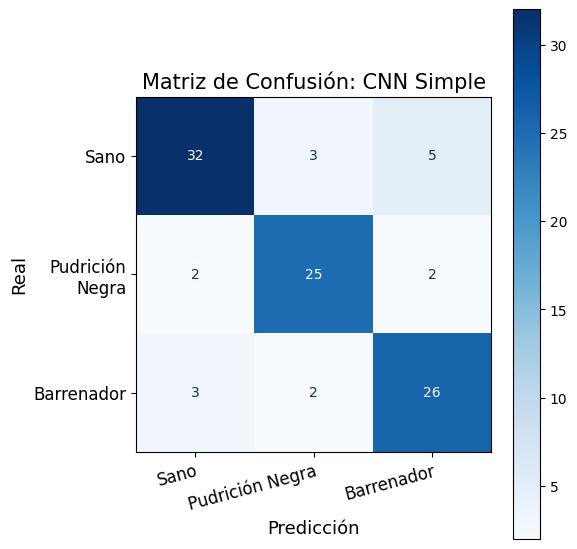

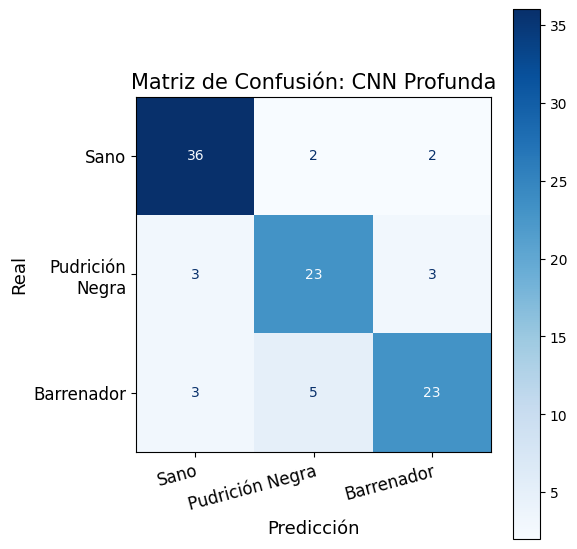

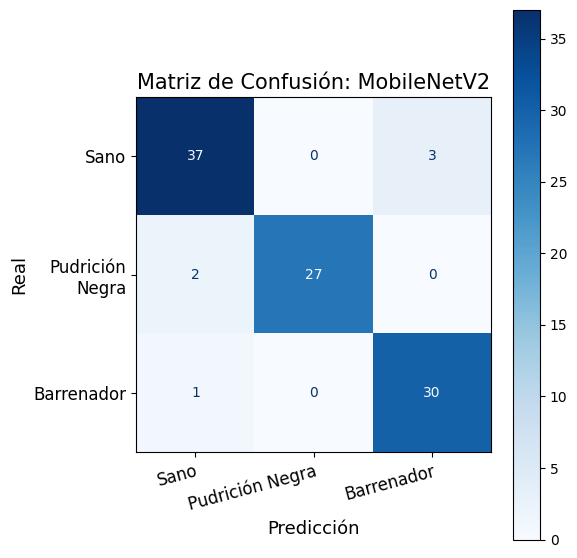

In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# SUBE TU CSV DE RESULTADOS
from google.colab import files
uploaded = files.upload()

df = pd.read_csv(list(uploaded.keys())[0])
y_true = df['y_true']
y_pred1 = df['y_pred1']
y_pred2 = df['y_pred2']
y_pred3 = df['y_pred3']

model_names = ['CNN Simple', 'CNN Profunda', 'MobileNetV2']
y_preds = [y_pred1, y_pred2, y_pred3]

labels = ["Sano", "Pudrición Negra", "Barrenador"]

for i, y_pred in enumerate(y_preds):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(6, 6))  # Más grande para nombres largos
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(ax=ax, cmap='Blues', values_format='d')
    plt.title(f"Matriz de Confusión: {model_names[i]}", fontsize=15)
    plt.xlabel('Predicción', fontsize=13)
    plt.ylabel('Real', fontsize=13)
    plt.xticks(fontsize=12, rotation=15, ha='right', wrap=True)  # Gira y ajusta nombres
    plt.yticks(fontsize=12, rotation=0, ha='right', wrap=True)
    plt.tight_layout()
    plt.show()
